# Image Compression

# Huffman Coding on Image

### Importing necessary libraries

In [1]:
import cv2
import numpy as np
from copy import deepcopy as cp

#### 

### Define Node class for storing intensities and probabilities

In [25]:
class Node:
    def __init__(self, f, p, isLeaf=0):
        self.freq = f         
        self.prob = p         
        self.word = ""        
        self.c = [None, None]
        self.isLeaf = isLeaf  

#### 

## Define main class 

##### At first reading input image and get number of rows,coloums and depth then calculate histogram and  probability of each value. then assign each probability to one node
##### Next, Creating Huffman Tree. upTree and downTree functions. In upTree we pop the least 2 probabilistic nodes and create a parent out of it. for downTree we do opposite.
##### Now by using bitarray library, we store bit(0) & bit (1) instead of char(0) and char(1) in encode string.

##### while decoding we are trying to read a list of int(0,1) from the compressed file, for this we used bitarray library. After reading the binary data into a list we will try to decode numbers out of it by traversing from the root node to one of the leaf nodes. we will stop if our length is $ r*c*d + 3 $

In [26]:
class Image:
    def __init__(self):
        self.path_in = ""               
        self.path_out = ""              
        self.im = np.zeros(1)          
        self.out = np.zeros(1)         
        self.image_data = np.zeros(1)   
        self.r = 0                      
        self.c = 0                      
        self.d = 0                      

        # histogram, ie frequency count of each data value
        self.hist = np.zeros(1)
        self.freqs = np.zeros(1)        

        # Dictionary with key as freqs and values as Probailities
        self.prob_dict = {}
        self.allNodes = []             
        self.leafNodes = {}            
        self.root = Node(-1, -1)        

        # Encoded String of Image,form: "01001010101011......", interpretation :  [r,c,d,[..pxls]]
        self.encodedString = ""

        # Decoded List of integers when read from .bin file, form : [456,342,3,34,2,120,44, ...... ], interpretation : [r,c,d,[..pxls]]
        self.decodeList = []

        # Binary from file in for of integers ie [0,1,0,0,1,0,1,0,1,0,1,0,1,1,......]
        self.binaryFromFile = []

    def checkCoding(self):
        return np.all(self.im == self.out)

    def readImage(self, path):
        self.path_in = path
        try:
            self.im = cv2.imread(path)
        except:
            print("Error in reading image")

    def initialise(self):
        self.r, self.c, self.d = self.im.shape

# Pushing r,c,d to encode into image_data list
        temp_list = self.im.flatten()
        temp_list = np.append(temp_list, self.r)
        temp_list = np.append(temp_list, self.c)
        temp_list = np.append(temp_list, self.d)

        self.image_data = temp_list

# Creating historgram from image_data to create frequencies.
        self.hist = np.bincount(
            self.image_data, minlength=max(256, self.r, self.c, self.d))
        total = np.sum(self.hist)

# Extracting the non-zero frequencies
        self.freqs = [i for i, e in enumerate(self.hist) if e != 0]
        self.freqs = np.array(self.freqs)

# Creating a dict of propabilities , with keys are intensities and value as propabilities
        for i, e in enumerate(self.freqs):
            self.prob_dict[e] = self.hist[e]/total

# Function to write output image
    def outImage(self, path):
        self.path_out = path
        try:
            cv2.imwrite(self.path_out, self.out)
        except:
            print("Error in writing the image")

# Creating Nodes for intensities
    def buildNodes(self):
        for key in self.prob_dict:
            leaf = Node(key, self.prob_dict[key], 1)
            self.allNodes.append(leaf)

# comparator function for sorting
    def prob_key(self, e):
        return e.prob

# Creating UPTREE
    def upTree(self):

        import heapq
        self.buildNodes()      

        # Sorting all Nodes in workspace to create uptree
        workspace = sorted(cp(self.allNodes), key=self.prob_key)
        while(1):
            c1 = workspace[0]
            c2 = workspace[1]
            workspace.pop(0)
            workspace.pop(0)

            # Creating A new node from  two smallest propability intensities
            new_node = Node(-1, c1.prob+c2.prob)
            new_node.c[0] = c1
            new_node.c[1] = c2

            workspace = list(heapq.merge(
                workspace, [new_node], key=self.prob_key))   # Pushing the created Node into Workspace
            # Break if probability of prepared node is 1, indicating preparing upTree is completed
            if(new_node.prob == 1.0):
                self.root = new_node      
                return

# Creating Down Tree ie assigning words to Leaf Nodes from Root
    def downTree(self, root, word):
        root.word = word
        if(root.isLeaf):
            self.leafNodes[root.freq] = root.word
        if(root.c[0] != None):
            self.downTree(root.c[0], word+'0')
        if(root.c[1] != None):
            self.downTree(root.c[1], word+'1')

    def huffmanAlgo(self):
        self.upTree()                  
        self.downTree(self.root, "")    

        dicti = {}                          
        # So that we need not access ("self.") every time that costs time, we just use dicti in place of self.leafNodes
        for key in self.leafNodes:
            dicti[key] = self.leafNodes[key]

        # Storing the self.encodedString in new variable encodedString
        # So that we need not accecess "self." every time,which cost more time
        encodedString = ""
        encodedString += dicti[self.r]
        encodedString += dicti[self.c]
        encodedString += dicti[self.d]

        # Note we are first encoding dimensions, and later encoding each pxl in 3rd dimension order , later while decoding we decode in the same way

        for i in range(self.r):
            for j in range(self.c):
                for ch in range(self.d):
                    encodedString += dicti[self.im[i][j][ch]]

        self.encodedString = encodedString

    def sendBinaryData(self, path):

        from bitstring import BitArray
        file = open(path, 'wb')
        obj = BitArray(bin=self.encodedString)
        obj.tofile(file)
        file.close()

    def decode(self, path):
        
        import bitarray
        self.binaryFromFile = bitarray.bitarray()
        with open(path, 'rb') as f:
            self.binaryFromFile.fromfile(f)

       

        decodeList = []
        root = self.root
        temp_root = cp(self.root)

        temp_r = 0
        temp_c = 0
        temp_d = 0

       

        for i, c_int in enumerate(self.binaryFromFile):
            if(temp_r != 0 and temp_c != 0 and temp_d != 0 and len(decodeList) == (temp_r*temp_c*temp_d + 3)):
                break
            if(temp_r == 0 and len(decodeList) >= 1):
                temp_r = decodeList[0]

            if(temp_c == 0 and len(decodeList) >= 2):
                temp_c = decodeList[1]

            if(temp_d == 0 and len(decodeList) >= 3):
                temp_d = decodeList[2]

            
            temp_root = temp_root.c[c_int]
            if(temp_root.isLeaf):
                decodeList.append(temp_root.freq)
                temp_root = root
                continue

        self.decodeList = decodeList

    def decodeIm(self, path):
        self.decode(path)

       

        decodeList = self.decodeList
        out_r = decodeList[0]
        decodeList.pop(0)
        out_c = decodeList[0]
        decodeList.pop(0)
        out_d = decodeList[0]
        decodeList.pop(0)

        out = np.zeros((out_r, out_c, out_d))

        # Filling the output image

        for i in range(len(decodeList)):
            id = i//out_d
            x = id//out_c
            y = id % out_c    
            z = i % out_d
            out[x][y][z] = decodeList[i]
        out = out.astype(dtype=int)
        self.out = out

    def huffmanCode(self, input_pth, compressed_pth="./compressed.bin", output_pth="./output.png", toCheck=0):
        

        import time

        self.readImage(input_pth)
        self.initialise()
        print('Initialization Done\n')

        s = time.time()
        print('Coding Image started\n')
        self.huffmanAlgo()
        print('Coding Image completed\n')
        e = time.time()

        print("\nOriginal Size of Image : ", self.r*self.c*self.d*8, " bits")
        print("\nCompressed Size : ", len(self.encodedString), " bits")
        print("\nCompressed factor : ", self.r *
              self.c*self.d*8/(len(self.encodedString)), "\n")

        print("Took ", e-s, " sec to encode input image\n")
        print('Sending coded data\n')
        self.sendBinaryData(compressed_pth)
        print('Soded data sent\n')

        s = time.time()

        print('Started decoding compressed image\n')
        self.decodeIm(compressed_pth)
        self.outImage(output_pth)
        print('Completed decoding compressed image ( open output image from the above mentioned path) \n')

        e = time.time()
        print("Took ", e-s, " sec to decode compressed image\n")
        if(toCheck):
            print("Are both images same : ", self.checkCoding())

In [43]:
image = Image()
image.huffmanCode("path/to/image1.png", "./compressed.bin",
                  "./output1.png", toCheck=1)

Initialization Done

Coding Image started

Coding Image completed


Original Size of Image :  6000000  bits

Compressed Size :  1025157  bits

Compressed factor :  5.8527620647374015 

Took  0.5694470405578613  sec to encode input image

Sending coded data

Soded data sent

Started decoding compressed image

Completed decoding compressed image ( open output image from the above mentioned path) 

Took  2.4248595237731934  sec to decode compressed image

Are both images same :  True


### Running Functions and perform Huffman coding for image compression

In [44]:
image = Image()
image.huffmanCode("path/to/image2.png", "./compressed.bin",
                  "./output2.png", toCheck=1)

Initialization Done

Coding Image started

Coding Image completed


Original Size of Image :  1572864  bits

Compressed Size :  1385121  bits

Compressed factor :  1.1355426710013061 

Took  0.21025657653808594  sec to encode input image

Sending coded data

Soded data sent

Started decoding compressed image

Completed decoding compressed image ( open output image from the above mentioned path) 

Took  2.388606548309326  sec to decode compressed image

Are both images same :  True


In [46]:
image = Image()
image.huffmanCode("path/to/image3.png", "./compressed.bin",
                  "./output3.png", toCheck=1)

Initialization Done

Coding Image started

Coding Image completed


Original Size of Image :  1572864  bits

Compressed Size :  1535694  bits

Compressed factor :  1.024204040648723 

Took  0.22598576545715332  sec to encode input image

Sending coded data

Soded data sent

Started decoding compressed image

Completed decoding compressed image ( open output image from the above mentioned path) 

Took  2.536747694015503  sec to decode compressed image

Are both images same :  True


### Reading all image for ploting

In [13]:
img1= cv2.imread('output1.png')
img2= cv2.imread('output2.png')
img3 = cv2.imread('output3.png')
img4= cv2.imread('image1.png')
img5= cv2.imread('image2.png')
img6 = cv2.imread('image3.png')

## Comparing original and compressed Images

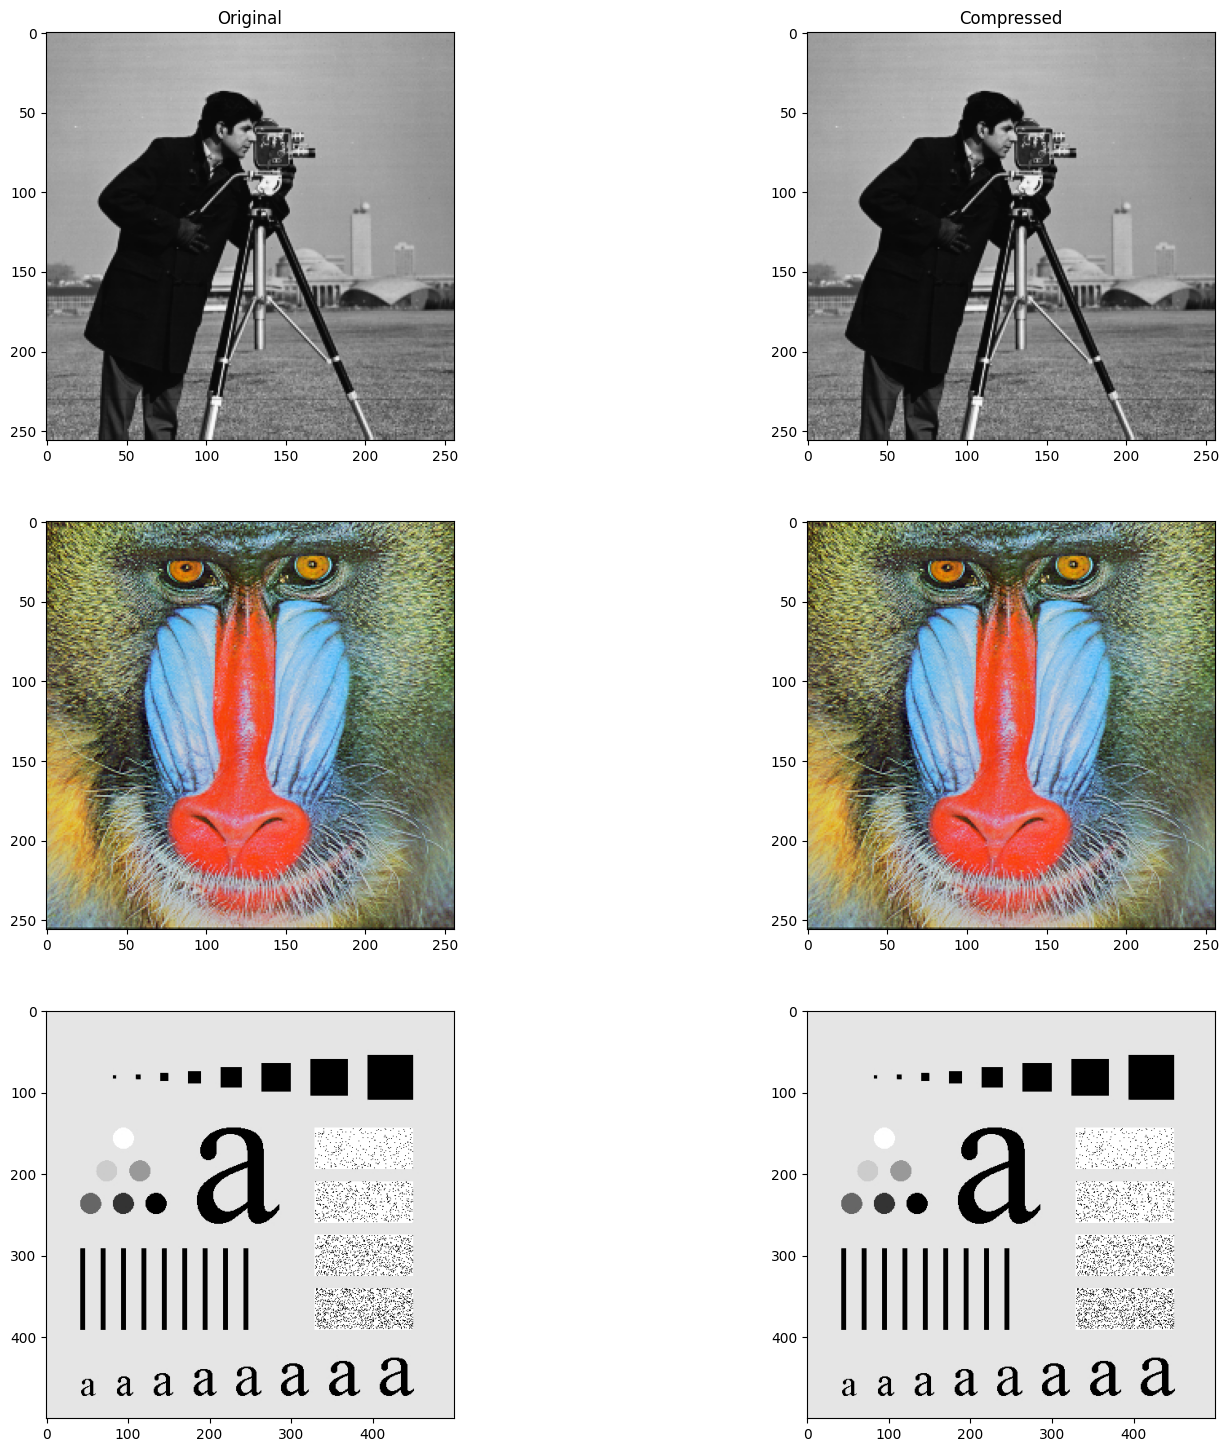

In [72]:
import matplotlib.pyplot as plt
fig = plt.figure (figsize = (18,18))
ax1 = fig.add_subplot (3,2,1)
ax1.imshow(img4)
ax1.title.set_text ('Original')

ax2 = fig.add_subplot (3,2,2)
ax2.imshow (img1)
ax2.title.set_text ('Compressed')

ax3= fig.add_subplot (3,2,3)
ax3.imshow (img5)

ax4= fig.add_subplot (3,2,4)
ax4.imshow (img2)

ax5= fig.add_subplot (3,2,5)
ax5.imshow(img6)

ax6= fig.add_subplot (3,2,6)
ax6.imshow(img3)

### As it turns out, there is no apparent difference between the compressed and original images

# 

# 

# Image Compression using: 
## a) Discrete Fourier Transform 
## b) Discrete Cosine Transform
## c) Walsh Hadamard Transform.

# 

## Part a: Image compression using DFT

### importing necessary libraries

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as rmse
import math
import time

In [39]:
file=  "testimage-256.jpg"
f = np.asarray(Image.open(file),np.uint8)
f= cv2.resize (f , [256,256])

### Creating sub images

In [24]:
def SubImages(I , N):
    import numpy as np 
    size = np.shape (I) [0]
    subs = []
    for j in range ((size - N)//N  +1 ):
        for i in range ((size - N)//N  +1) : 
            subs.append( I[ i*N : (i+1)*N   ,  j*N : (j+1)*N   ] ) 
    return subs  

### Reconstructs Image from Sub images

In [25]:
def RecFromSubs(subs , N ,size):
    import numpy as np
    subs_copy = subs.copy()
    subs_copy.reverse()
    rec = np.zeros([size,size]).astype(np.complex128) 
    for j in range ((size - N)//N  +1 ):    
        for i in range ((size - N)//N  +1) :         
            rec[i*N : (i+1)*N   ,  j*N : (j+1)*N  ] = subs_copy.pop()  
    return rec

In [26]:
def DFT8(f) :
        
    #% Pre Transform
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt
    f_subs = SubImages(f , 8) # make 8 by 8 SubImages on f
    f_compressed_subs = np.zeros([8 , 8 ,1024])
    f_fft_subs = []
    compressed = np.zeros([4,4,1024])
    for i in range (1024):  
        f_fft_subs.append (np.fft.fft2(f_subs[i]) );
        f_compressed_subs[0:4,0:4,i] = f_fft_subs[i][0:4,0:4]
        compressed[:,:,i] = f_compressed_subs[0:4,0:4,i] 
    

    f_compressed_subs_list= []
    for _ in range (1024):
        f_compressed_subs_list.append(f_compressed_subs[:,:,_])
    Truncated = RecFromSubs( f_compressed_subs_list, 8 ,256)
    inverse_f_compressed_subs = np.zeros([8 , 8 ,1024])
    
    for i in range (1024):
        inverse_f_compressed_subs[:,:,i] =np.fft.ifft2( f_compressed_subs[:,:,i]  )

    tolist = []
    for _ in range (1024):
        tolist.append(inverse_f_compressed_subs[:,:,_])
    recc = np.real(RecFromSubs( tolist, 8 ,256))
    
    
    testlist = []
    for _ in range (1024 ):
        testlist.append(compressed[:,:,_])
    tes = RecFromSubs(testlist , 4 ,128)

    
    testlist = []
    for _ in range (1024 ):
        testlist.append(compressed[:,:,_])
    
    return recc , tes

### Compressing image using DFT

C:\Users\Mojtaba\AppData\Local\Temp\ipykernel_13448\2503014910.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  f_compressed_subs[0:4,0:4,i] = f_fft_subs[i][0:4,0:4]
C:\Users\Mojtaba\AppData\Local\Temp\ipykernel_13448\2503014910.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  inverse_f_compressed_subs[:,:,i] =np.fft.ifft2( f_compressed_subs[:,:,i]  )
C:\Users\Mojtaba\AppData\Local\Temp\ipykernel_13448\1594464760.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  rec[:,:,_],compressed_dft[:,:,_]  = DFT8 (f[:,:,_])


RMSE between original and compressed image is :  9.3085169243805


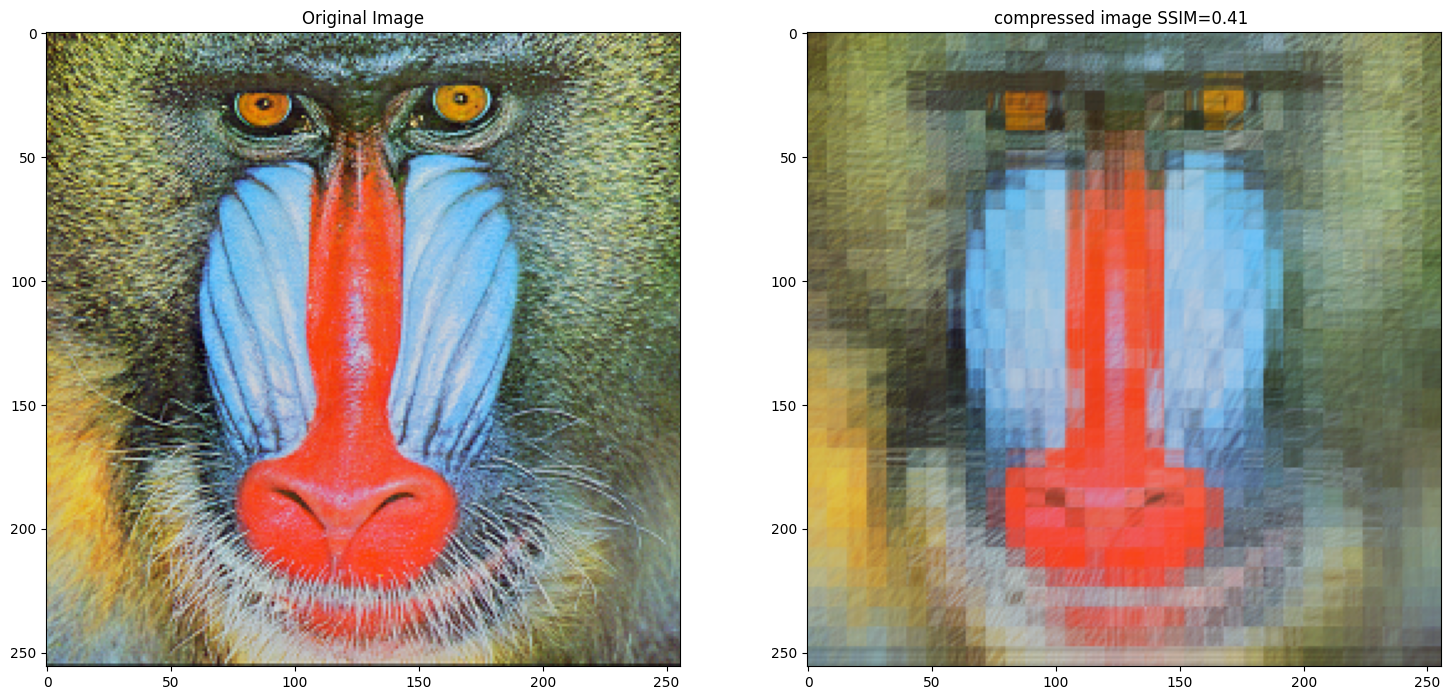

In [14]:
rec = np.zeros([256,256,3])
compressed_dft = np.zeros([128,128,3])

for _ in range (3):
    
    rec[:,:,_],compressed_dft[:,:,_]  = DFT8 (f[:,:,_])

rec = np.asarray(rec, dtype = 'uint8')

fhat = f [:,:,0:3]
point = np.zeros ([3])
RMSE = np.zeros ([3])
f_norm =  cv2.normalize(f, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
rec_norm =  cv2.normalize(rec, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

for i in range (3):
    point[i] = ssim(fhat[:,:,i], rec[:,:,i],data_range=255)
    RMSE[i] = math.sqrt(np.square(np.subtract(rec[:,:,i],fhat[:,:,i])).mean() )   

avg_point = np.mean(point)

avg_RMSE = np.mean(RMSE)
  
fig1 = plt.figure (figsize = (18,18))
ax1 = fig1.add_subplot (1,2,1)
ax1.imshow(img5)
ax1.title.set_text ('Original Image')

ax2 = fig1.add_subplot (1,2,2)
ax2.imshow (rec)
ax2.title.set_text ('compressed image SSIM={} '.format( round(avg_point,2)))
print ('RMSE between original and compressed image is : ' , avg_RMSE) 

C:\Users\Mojtaba\AppData\Local\Temp\ipykernel_13448\2503014910.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  f_compressed_subs[0:4,0:4,i] = f_fft_subs[i][0:4,0:4]
C:\Users\Mojtaba\AppData\Local\Temp\ipykernel_13448\2503014910.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  inverse_f_compressed_subs[:,:,i] =np.fft.ifft2( f_compressed_subs[:,:,i]  )


RMSE between original and compressed image is :  39.902587797220406


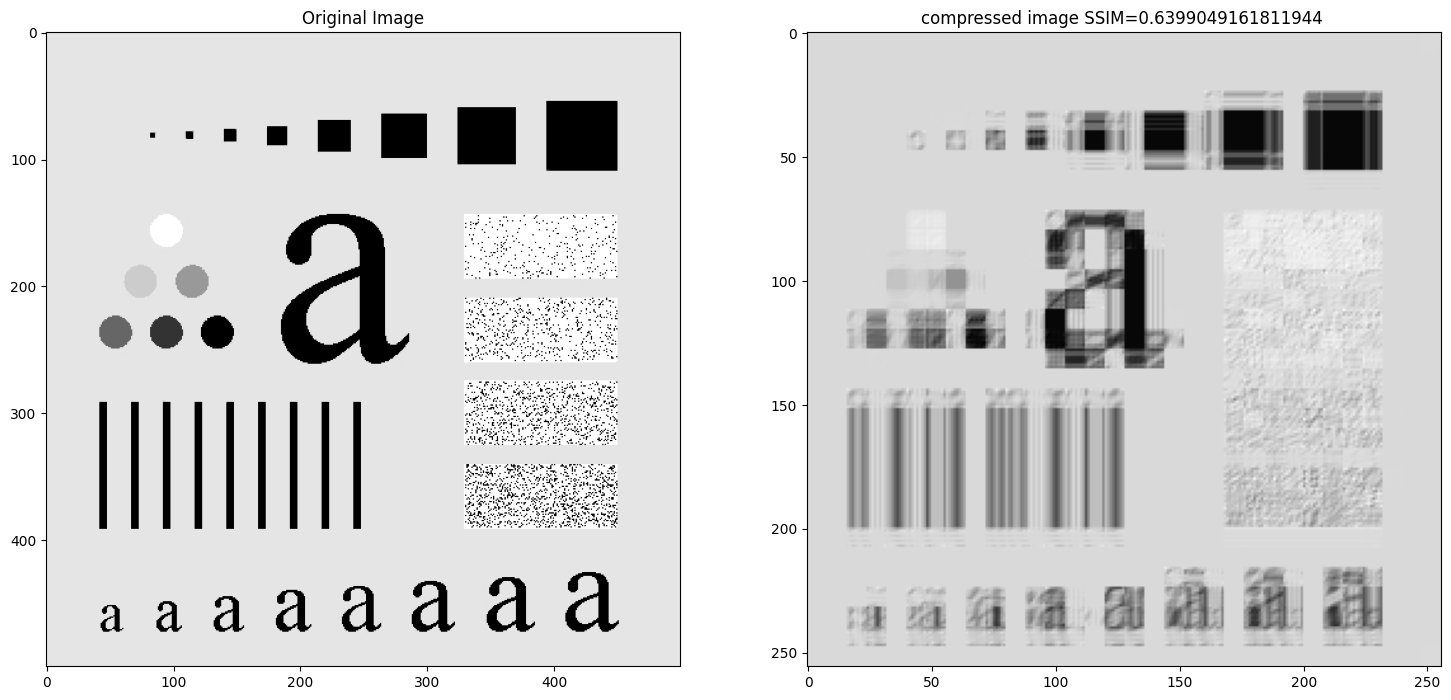

In [28]:
st = time.time()

rec,compressed_dft  = DFT8 (f)
end = time.time()

elapsed_time = end - st

f_norm =  cv2.normalize(f, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
rec_norm =  cv2.normalize(rec, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

point = ssim(f, rec,data_range=f.max() - f.min())
RMSE = math.sqrt(np.square(np.subtract(rec,f)).mean())
                 
figa = plt.figure (figsize = (18,18))
ax1 = figa.add_subplot (1,2,1)
ax1.imshow(img6 , cmap='gray')
ax1.title.set_text ('Original Image')

ax2 = figa.add_subplot (1,2,2)
ax2.imshow (rec , cmap='gray')
ax2.title.set_text ('compressed image SSIM={} '.format(point))
print ('RMSE between original and compressed image is : ' , RMSE)                  

# 

### Part b: Image compression using DCT

In [33]:
def DCT8 (f):
#% Pre Transform
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.fftpack import fft, dct , idct
    from PIL import Image
    f_subs = SubImages(f , 8) # make 8 by 8 SubImages on f
    f_compressed_subs = np.zeros([8 , 8 ,1024])
    compressed = np.zeros([4 , 4 ,1024])
    f_fft_subs = []
    compressed = np.zeros([4,4,1024])
    for i in range (1024):
        
        f_fft_subs.append (dct(dct(f_subs[i].T, norm='ortho').T, norm='ortho') );
        
        f_compressed_subs[0:4,0:4,i] = f_fft_subs[i][0:4,0:4]
        
        compressed[:,:,i] = f_compressed_subs[0:4,0:4,i] 
    
       

    f_compressed_subs_list= []
    for _ in range (1024):
        f_compressed_subs_list.append(f_compressed_subs[:,:,_])
    Truncated = RecFromSubs( f_compressed_subs_list, 8 ,256)
    inverse_f_compressed_subs = np.zeros([8 , 8 ,1024])
    
    
    for i in range (1024):
        
        inverse_f_compressed_subs[:,:,i] =idct(idct(f_compressed_subs[:,:,i] .T, norm='ortho').T, norm='ortho')
    tolist = []
    for _ in range (1024):
        
        tolist.append(inverse_f_compressed_subs[:,:,_])
   
    recc = np.real(RecFromSubs( tolist, 8 ,256))
    
    testlist = []
    for _ in range (1024 ):
        testlist.append(compressed[:,:,_])

    tes = RecFromSubs(testlist , 4 ,128)
    return recc , tes

C:\Users\Mojtaba\AppData\Local\Temp\ipykernel_10628\667268765.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  rec[:,:,_],compressed_dft[:,:,_]  = DCT8 (f[:,:,_])


RMSE between original and compressed image is :  8.696451886808427


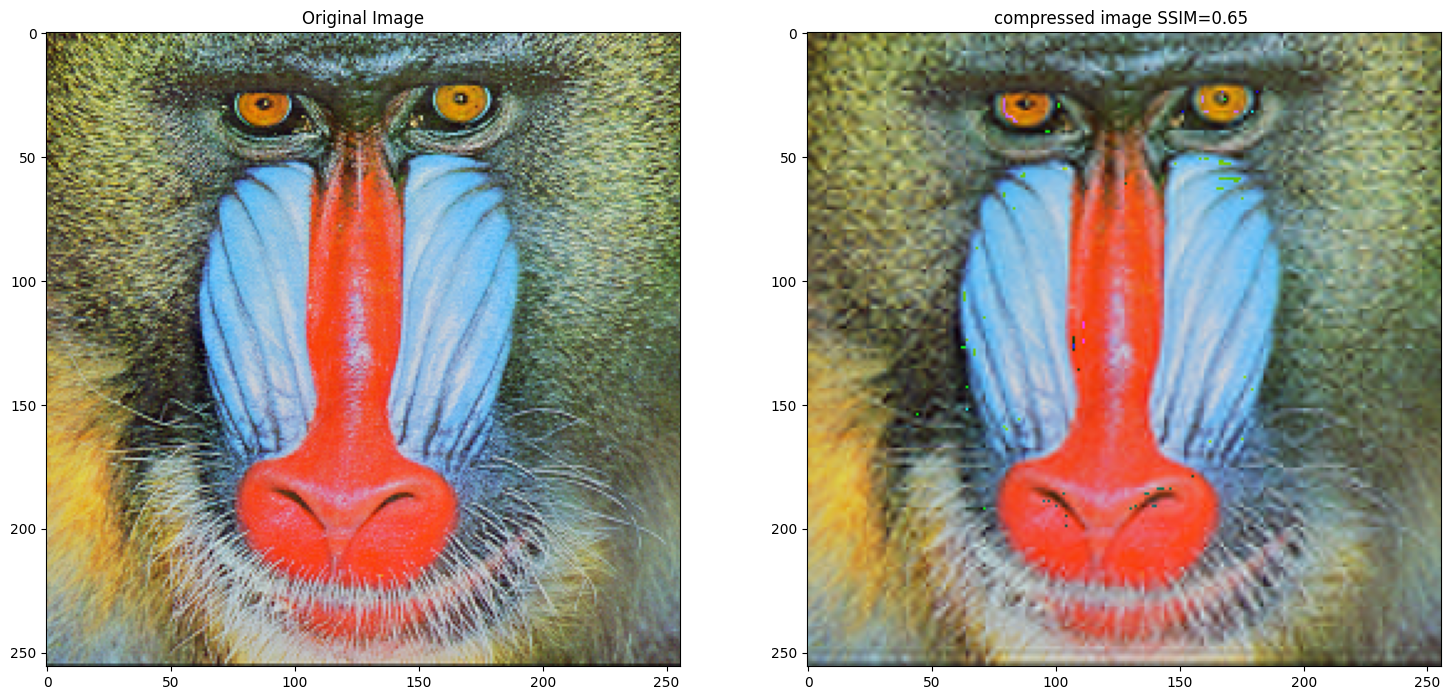

In [91]:
rec = np.zeros([256,256,3])
compressed_dft = np.zeros([128,128,3])

for _ in range (3):
    
    rec[:,:,_],compressed_dft[:,:,_]  = DCT8 (f[:,:,_])

rec = np.asarray(rec, dtype = 'uint8')

fhat = f [:,:,0:3]
point = np.zeros ([3])
RMSE = np.zeros ([3])
f_norm =  cv2.normalize(f, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
rec_norm =  cv2.normalize(rec, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

for i in range (3):
    point[i] = ssim(fhat[:,:,i], rec[:,:,i],data_range=255)
    RMSE[i] = math.sqrt(np.square(np.subtract(rec[:,:,i],fhat[:,:,i])).mean() )
 
    

avg_point = np.mean(point)

avg_RMSE = np.mean(RMSE)
  


fig1 = plt.figure (figsize = (18,18))
ax1 = fig1.add_subplot (1,2,1)
ax1.imshow(img5)
ax1.title.set_text ('Original Image')

ax2 = fig1.add_subplot (1,2,2)
ax2.imshow (rec)
ax2.title.set_text ('compressed image SSIM={} '.format( round(avg_point,2)))
print ('RMSE between original and compressed image is : ' , avg_RMSE) 

RMSE between original and compressed image is :  11.752981871497653


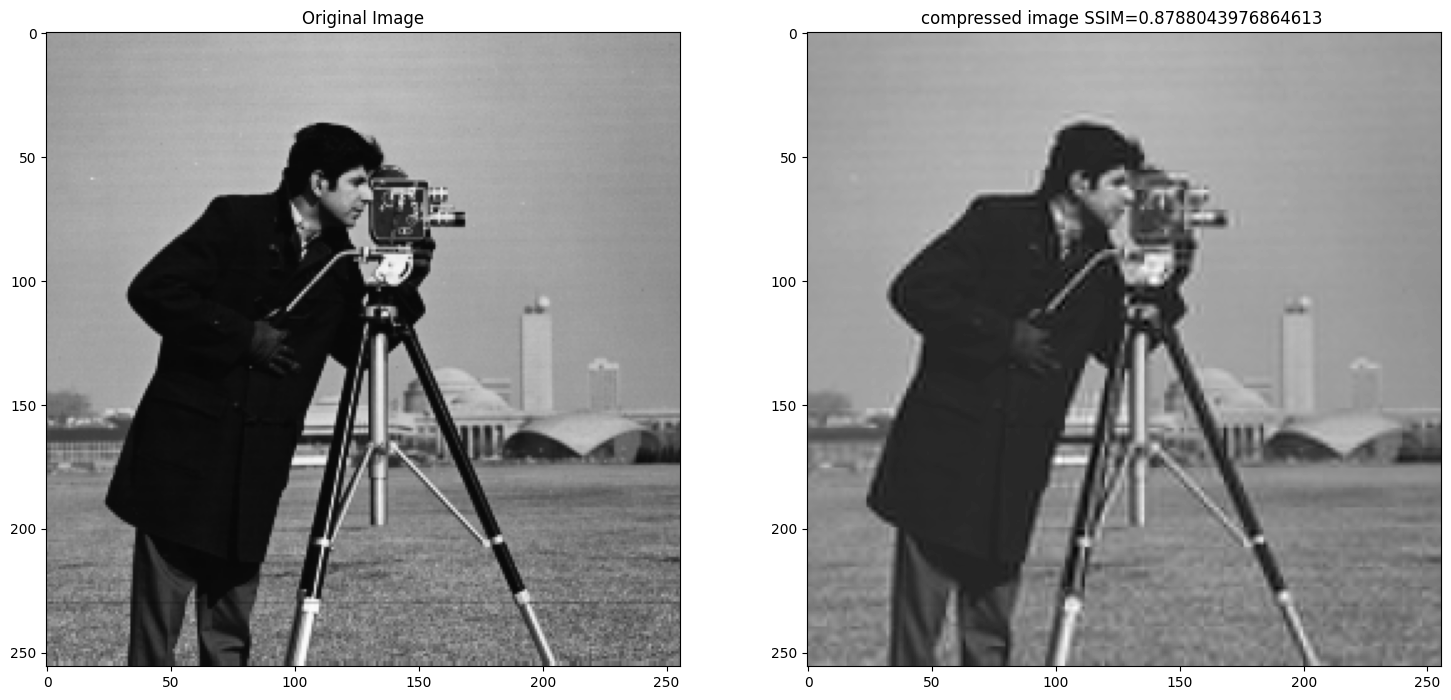

In [36]:
st = time.time()

rec,compressed_dft  = DCT8 (f)
end = time.time()

elapsed_time = end - st

f_norm =  cv2.normalize(f, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
rec_norm =  cv2.normalize(rec, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

point = ssim(f, rec,data_range=f.max() - f.min())
RMSE = math.sqrt(np.square(np.subtract(rec,f)).mean())
                 
figa = plt.figure (figsize = (18,18))
ax1 = figa.add_subplot (1,2,1)
ax1.imshow(img4 , cmap='gray')
ax1.title.set_text ('Original Image')

ax2 = figa.add_subplot (1,2,2)
ax2.imshow (rec , cmap='gray')
ax2.title.set_text ('compressed image SSIM={} '.format(point))
print ('RMSE between original and compressed image is : ' , RMSE)   

### b and p definitions for WHT transform

In [37]:
def b(z,k):
    b = int("{0:03b}".format(z)[::-1] [k])
    return b


def p(u,i):
    m = 3
    if (i==0):
        p = b(u,m-1)
    else:   
        p = b(u,m-i) + b(u,m-(i+1))   
    return p    
    
def WHT8 (f):
    #% Pre Transform
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt

    f_subs = SubImages(f , 8) # make 8 by 8 SubImages on f
    
    # Transform
    
    m = 3
    summ=np.zeros([8,8,8,8])
    g=np.zeros([8,8,8,8])
    fg  = np.zeros([8,8,8,8,1024])
    T = np.zeros([8,8,1024])
    
    for j in range (1024):
        print("\rperforming WHT Transform {} of 1024".format(j) ,end='\r')
        summ=np.zeros([8,8,8,8])
        
        for  u in range (8):
            for  v in range (8):
                for  x in range (8):
                        for  y in range (8):
                            for  i in range (m):
                
                                summ[x,y,u,v] =  summ[x,y,u,v]  + (b(x,i)*p(u,i) + b(y,i)*p(v,i))
                                g[x,y,u,v] = (1/8) * (-1) **(summ[x,y,u,v])
                                fg[x,y,u,v,j] = f_subs[j][x,y] * g[x,y,u,v]
                                T[u,v,j] = np.sum(fg[:,:,u,v,j], axis = (0,1)  )
                                
    # Process    

    Trunc = np.zeros([8,8,1024])                            
    for i in range (1024 ): 
        Trunc[0:4,0:4,i] = T[0:4,0:4,i]
        
    f_compressed_subs_list= []
    for _ in range (1024):
        f_compressed_subs_list.append(Trunc[:,:,_])
    Truncated = RecFromSubs( f_compressed_subs_list, 8 ,256)
       
                                                           
    # Inverse Transform
    
    
    invsumm=np.zeros([8,8,8,8])
    invfg  = np.zeros([8,8,8,8,1024])
    invT = np.zeros([8,8,1024])
    invg=np.zeros([8,8,8,8])
    for j in range (1024):
        
        print("\rperforming Inverse WHT Transform {} of 1024".format(j) ,end='\r')
        invsumm=np.zeros([8,8,8,8])
        for  x in range (8):
            for  y in range (8):
                for  u in range (8):
                        for  v in range (8):
                            for  i in range (m):
                            
                                invsumm[x,y,u,v] =  invsumm[x,y,u,v]  + (b(x,i)*p(u,i) + b(y,i)*p(v,i))
                                invg[x,y,u,v] = (1/8) * (-1) **(invsumm[x,y,u,v])
                                invfg[x,y,u,v,j] = Trunc[u,v,j] * invg[x,y,u,v]
                                invT[x,y,j] = np.sum(invfg[x,y,:,:,j], axis = (0,1)  )
                                
    tolist = []
    for _ in range (1024):
        tolist.append(invT[:,:,_])
    
    # merge reconstructed SubImages into one 
    recc = np.real(RecFromSubs( tolist, 8 ,256))
    
    # Show Reconstructed 
    
    return recc,Truncated

C:\Users\Mojtaba\AppData\Local\Temp\ipykernel_10628\23292835.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  rec[:,:,_],compressed_dft[:,:,_]  = WHT8 (f[:,:,_])


RMSE between original and compressed image is :  8.714139316239306


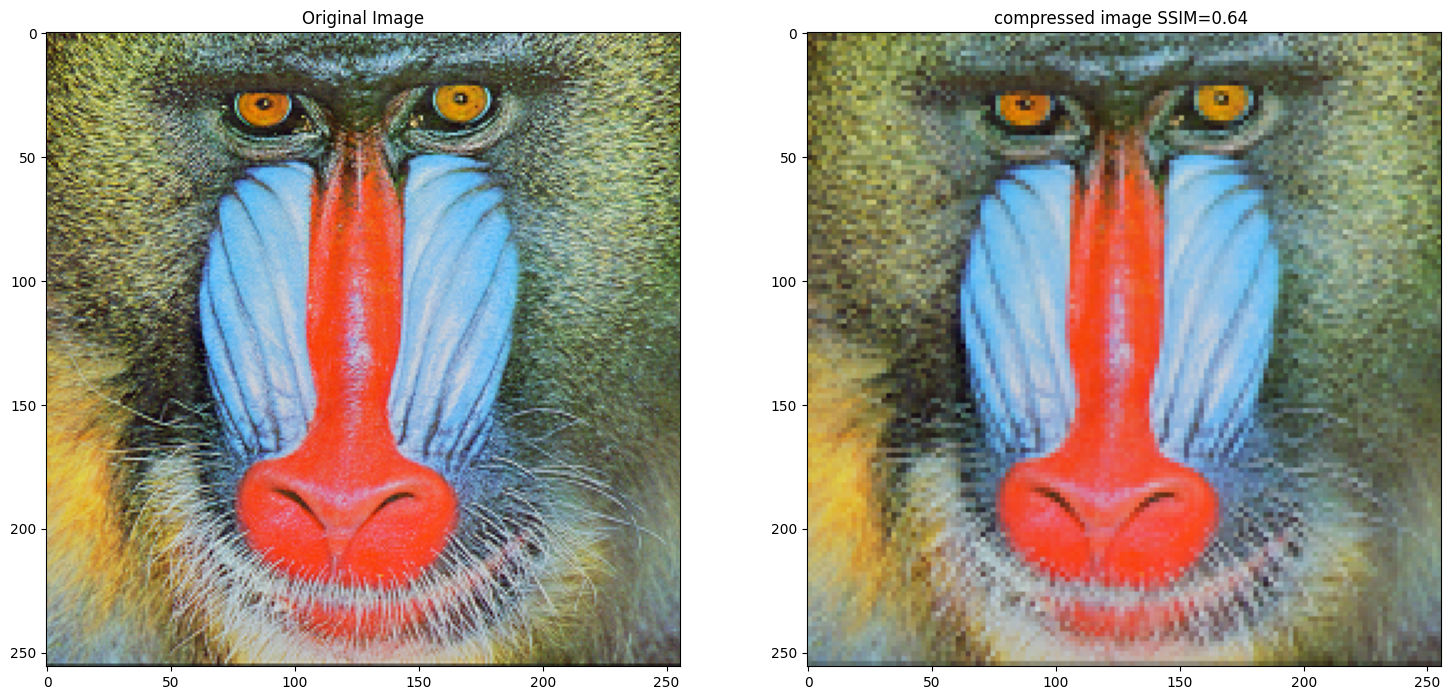

In [98]:
rec = np.zeros([256,256,3])
compressed_dft = np.zeros([256,256,3])

for _ in range (3):
    
    rec[:,:,_],compressed_dft[:,:,_]  = WHT8 (f[:,:,_])

rec = np.asarray(rec, dtype = 'uint8')

fhat = f [:,:,0:3]
point = np.zeros ([3])
RMSE = np.zeros ([3])
f_norm =  cv2.normalize(f, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
rec_norm =  cv2.normalize(rec, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

for i in range (3):
    point[i] = ssim(fhat[:,:,i], rec[:,:,i],data_range=255)
    RMSE[i] = math.sqrt(np.square(np.subtract(rec[:,:,i],fhat[:,:,i])).mean() )
 
    

avg_point = np.mean(point)

avg_RMSE = np.mean(RMSE)
  


fig1 = plt.figure (figsize = (18,18))
ax1 = fig1.add_subplot (1,2,1)
ax1.imshow(img5)
ax1.title.set_text ('Original Image')

ax2 = fig1.add_subplot (1,2,2)
ax2.imshow (rec)
ax2.title.set_text ('compressed image SSIM={} '.format( round(avg_point,2)))
print ('RMSE between original and compressed image is : ' , avg_RMSE) 


RMSE between original and compressed image is :  24.933322030675164


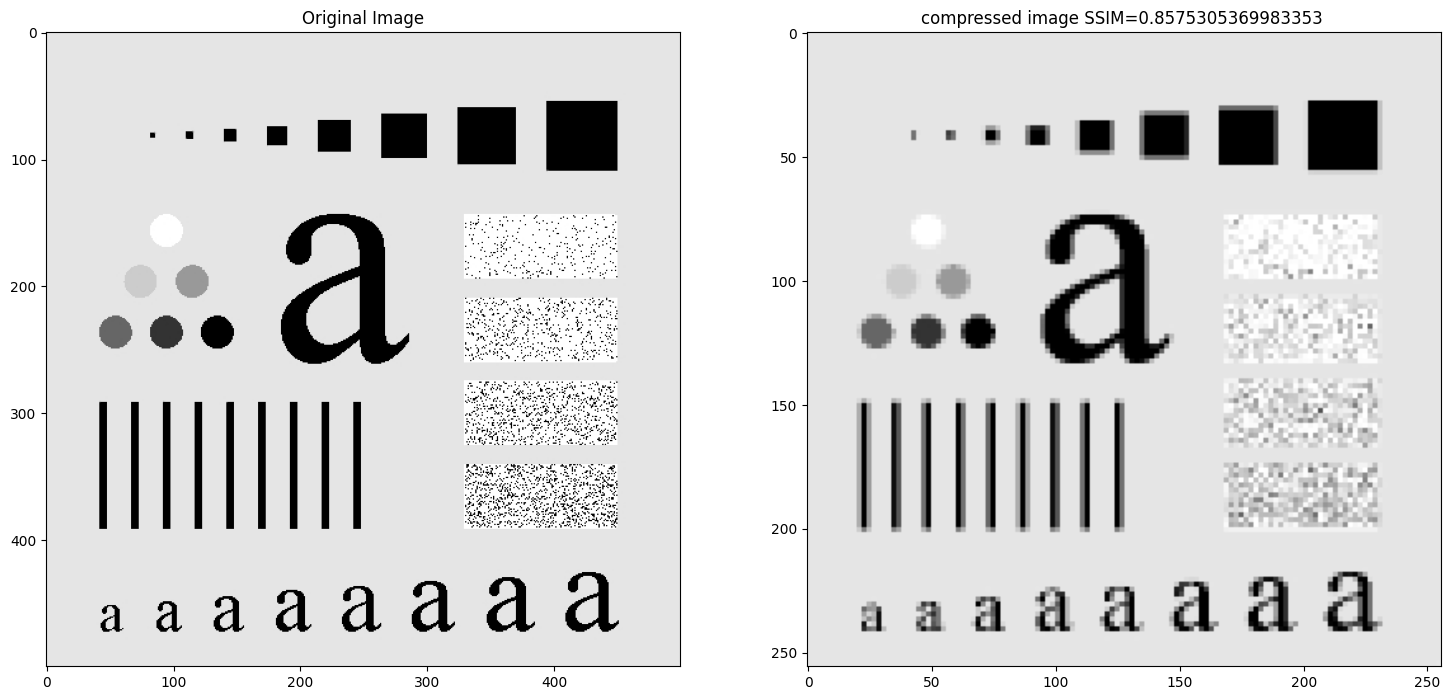

In [40]:
st = time.time()

rec,compressed_dft  = WHT8 (f)
end = time.time()

elapsed_time = end - st

f_norm =  cv2.normalize(f, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
rec_norm =  cv2.normalize(rec, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

point = ssim(f, rec,data_range=f.max() - f.min())
RMSE = math.sqrt(np.square(np.subtract(rec,f)).mean() )

figa = plt.figure (figsize = (18,18))
ax1 = figa.add_subplot (1,2,1)
ax1.imshow(img6 , cmap='gray')
ax1.title.set_text ('Original Image')

ax2 = figa.add_subplot (1,2,2)
ax2.imshow (rec , cmap='gray')
ax2.title.set_text ('compressed image SSIM={} '.format(point))
print ('RMSE between original and compressed image is : ' , RMSE)   